In [162]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
sp500_constituents_directory = '../data/sp500'

In [163]:
#Get all sp500 constituents into a single dataframe:
sp500_df = pd.read_csv('../data/_SPXD.csv')
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df['spx_return'] = sp500_df['close'].pct_change()
print(f'The SP500 dataframe holds {sp500_df["close"].isna().sum()} missing "close" values')
sp500_df.dropna(subset=['spx_return'], inplace=True)
sp500_df['spx_return'].describe()

The SP500 dataframe holds 0 missing "close" values


count    26583.000000
mean         0.000346
std          0.012447
min         -0.204669
25%         -0.004582
50%          0.000515
75%          0.005531
max          0.165954
Name: spx_return, dtype: float64

In [164]:
risk_free_rate_df = pd.read_csv('../data/ITUSA1D.csv', index_col=0)
risk_free_rate_df['date'] = pd.to_datetime(risk_free_rate_df['date'])
risk_free_rate_df['rf'] = risk_free_rate_df['close'] / 100 / 252
risk_free_rate_df = risk_free_rate_df[['date', 'rf']]
print(risk_free_rate_df['rf'].isna().sum())
risk_free_rate_df.head()

0


,date,rf
0,2001-07-31,0.000146
1,2001-08-01,0.000145
2,2001-08-02,0.000145
3,2001-08-03,0.000144
4,2001-08-06,0.000144


In [165]:
df = pd.DataFrame()
for asset in os.listdir(sp500_constituents_directory):
    asset_df = pd.read_csv(f'{sp500_constituents_directory}/{asset}', index_col=0)
    asset_df['date'] = pd.to_datetime(asset_df['date'])
    if (asset_df['close'] == 0).sum() > 0:
        print(asset)
        asset_df['close'].replace(0, np.nan, inplace=True)
        asset_df['close'] = asset_df['close'].ffill()
    asset_df['return'] = asset_df['close'].pct_change()
    asset_df.dropna(subset=['return'], inplace=True)
    asset_df = asset_df[['date', 'symbol', 'series_id', 'close', 'return']]
    asset_df = pd.merge(asset_df, sp500_df[['date', 'spx_return']], on='date')
    asset_df = pd.merge(asset_df, risk_free_rate_df[['date', 'rf']], on='date')
    if len(df) == 0:
        df = asset_df
    else:
        # concat
        df = pd.concat([df, asset_df])
df = df[df['date'] > '2001-01-01']

KR.csv


/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/2182284707.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  asset_df['close'].replace(0, np.nan, inplace=True)


In [166]:
df['spx_return'] = df['spx_return'] - df['rf']
df['return'] = df['return'] - df['rf']

In [167]:
df['return'].describe()

count    2.651745e+06
mean     5.244753e-04
std      2.251524e-02
min     -8.206310e-01
25%     -8.869747e-03
50%      4.758446e-04
75%      9.851501e-03
max      4.803088e+00
Name: return, dtype: float64

In [168]:
# Print the 10 rows with the highest df['return']
df['return_z_score'] = (df['return'] - df['return'].mean()) / df['return'].std()
print(len(df))
df = df[(df['return_z_score'] <= 3) & (df['return_z_score'] >= -3)]
print(len(df))

2651745
2609197


In [169]:
all_assets = df['symbol'].unique().tolist()
capm_betas = []
capm_betas_dict = {}
for asset, asset_data in df.groupby('symbol'):
    X = asset_data['spx_return']
    X = sm.add_constant(X)
    y = asset_data['return']
    
    model = sm.OLS(y, X)
    results = model.fit()
    capm_betas.append({'symbol': asset, 'capm':results.params[1], 'expected_return': asset_data['return'].mean()})
    capm_betas_dict[asset] = results.params[1]

/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/2318724424.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capm_betas.append({'symbol': asset, 'capm':results.params[1], 'expected_return': asset_data['return'].mean()})
/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/2318724424.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  capm_betas_dict[asset] = results.params[1]
/var/folders/jy/_2t8f9sx1hs8nmxchkp2wrhc0000gn/T/ipykernel_62566/2318724424.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be trea

In [170]:
capm_betas = pd.DataFrame(capm_betas)
capm_betas.head()

,symbol,capm,expected_return
0,A,1.130476,0.000374
1,AAPL,1.024139,0.001079
2,ABBV,0.660826,0.000818
3,ABNB,1.372204,-0.000331
4,ABT,0.625082,0.000371


In [171]:
df = pd.merge(df, capm_betas, on='symbol')
df.head()

,date,symbol,series_id,close,return,spx_return,rf,return_z_score,capm,expected_return
0,2001-07-31,CSCO,58375,19.22,0.017324,0.005425,0.000146,0.746137,1.043992,0.000364
1,2001-08-01,CSCO,58375,20.30,0.056047,0.003736,0.000145,2.465980,1.043992,0.000364
2,2001-08-02,CSCO,58375,20.25,-0.002608,0.003819,0.000145,-0.139122,1.043992,0.000364
3,2001-08-03,CSCO,58375,20.05,-0.010021,-0.005387,0.000144,-0.468352,1.043992,0.000364
4,2001-08-06,CSCO,58375,19.54,-0.025580,-0.011565,0.000144,-1.159416,1.043992,0.000364


In [172]:
factors=['capm']

In [173]:
# Dictionary to store the risk premiums (gamma values) for each time period
risk_premiums = {}

# Grouping the DataFrame by reporting periods (time periods)
all_periods = df['date'].nunique()
for period, period_group in df.groupby('date'):

    # The dependent variable (returns for the current time period)
    y = period_group['return']
    X = period_group[factors]
    X = sm.add_constant(X)

    # Fit the Fama-Macbeth regression for this period
    model = sm.OLS(y, X).fit()

    # Store the risk premiums (gamma coefficients) for this period
    risk_premiums[period] = model.params

In [174]:
rp_df = pd.DataFrame.from_dict(risk_premiums, orient='index')
rp_df.head()

,const,capm
2001-07-31,0.004474,0.001250
2001-08-01,-0.017151,0.021842
2001-08-02,-0.007234,0.010746
2001-08-03,0.003048,-0.006948
2001-08-06,-0.004626,-0.006124


<Axes: >

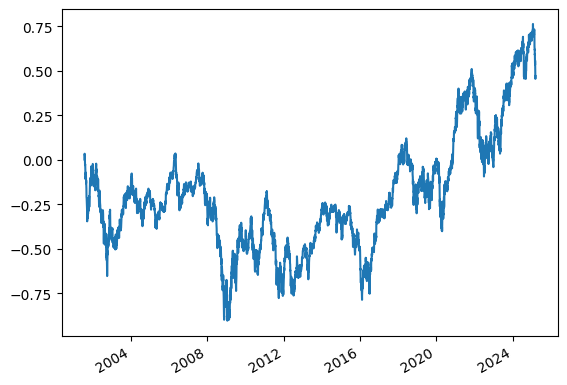

In [175]:
rp_df['capm'].cumsum().plot()

<Axes: >

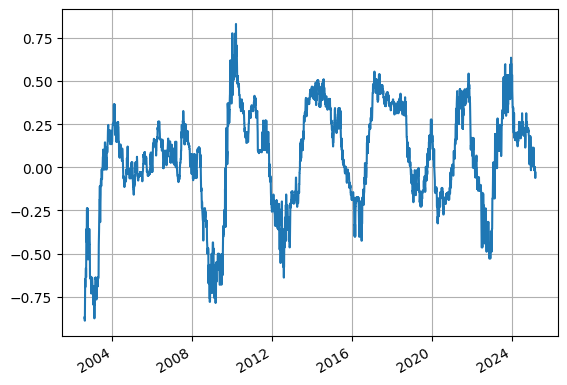

In [189]:
(rp_df['capm'].rolling(window=252).median()*252).plot(grid=True)

In [187]:
rp_df['capm'].median()*100*252

np.float64(8.386106952747694)